<a href="https://colab.research.google.com/github/jh-4166640/Machine-Learning-Lecture/blob/main/FinancePredictModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----
#주가 예측 텀프로젝트
-----

###Train / Test divied

In [19]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pdrhrk

shinpoong_pharm_finance = yf.download('019170.KS', start='2022-05-01') # 주가가 큰 변동이 없을 때
robostar_finance = yf.download('090360.KQ', start='2024-04-01')        # 변동성이 가장 큰 주식으로 이상치 데이터로 사용하기 위함
daihan_pharm_finance = yf.download('023910.KQ', start='2021-09-01')    # 큰 변동성이 최대한 없는 부분부터
dbhitek_finance = yf.download('000990.KS', start='2022-07-01')         # 상승하는 부분부터 사용하기 위해서
skdnd_finance = yf.download('210980.KS', start='2024-04-01')           # 너무 큰 급락 폭을무시하기 위해서

# train, test divied
shinpoong_train_idx = np.where('2025-10-20'>shinpoong_pharm_finance.index)
robostar_train_idx = np.where('2025-10-20'>robostar_finance.index)
daihan_train_idx = np.where('2025-10-20'>daihan_pharm_finance.index)
dbhitek_train_idx = np.where('2025-10-20'>dbhitek_finance.index)
skdnd_train_idx = np.where('2025-10-20'>skdnd_finance.index)

shinpoong_test_idx = np.where('2025-10-20'<=shinpoong_pharm_finance.index)
robostar_test_idx = np.where('2025-10-20'<=robostar_finance.index)
daihan_test_idx = np.where('2025-10-20'<=daihan_pharm_finance.index)
dbhitek_test_idx = np.where('2025-10-20'<=dbhitek_finance.index)
skdnd_test_idx = np.where('2025-10-20'<=skdnd_finance.index)

print(shinpoong_pharm_finance)



/tmp/ipython-input-4028347977.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  shinpoong_pharm_finance = yf.download('019170.KS', start='2022-05-01') # 주가가 큰 변동이 없을 때
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4028347977.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  robostar_finance = yf.download('090360.KQ', start='2024-04-01')        # 변동성이 가장 큰 주식으로 이상치 데이터로 사용하기 위함
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4028347977.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  daihan_pharm_finance = yf.download('023910.KQ', start='2021-09-01')    # 큰 변동성이 최대한 없는 부분부터
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4028347977.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dbhitek_finance = yf.download('000990.KS', s

Price          Close      High       Low      Open    Volume
Ticker     019170.KS 019170.KS 019170.KS 019170.KS 019170.KS
Date                                                        
2022-05-02   29850.0   30400.0   29750.0   29900.0    340238
2022-05-03   29100.0   30150.0   29050.0   29800.0    377990
2022-05-04   28700.0   29500.0   28350.0   29250.0    370145
2022-05-06   28300.0   28600.0   27900.0   28150.0    299587
2022-05-10   27900.0   28200.0   26700.0   27650.0    376437
...              ...       ...       ...       ...       ...
2025-12-03   15050.0   15230.0   14770.0   14840.0    359433
2025-12-04   14620.0   15110.0   14530.0   15060.0    294759
2025-12-05   14770.0   14790.0   14440.0   14650.0    249765
2025-12-08   14770.0   15360.0   14570.0   14770.0    536778
2025-12-09   14500.0   14870.0   14490.0   14780.0    283545

[881 rows x 5 columns]


###기술적 지표 추가

In [4]:

# NaN 제거 - GPT 활용
def clean_nan(data, method="drop"):
    """
    data: pandas DataFrame
    method: 'drop', 'bfill', 'ffill', 'bothfill'
    """
    if method == "drop":
        return data.dropna()

    elif method == "bfill":
        return data.fillna(method="bfill")

    elif method == "ffill":
        return data.fillna(method="ffill")

    elif method == "bothfill":
        return data.fillna(method="ffill").fillna(method="bfill")

    else:
        raise ValueError("method must be: 'drop', 'bfill', 'ffill', 'bothfill'")


# 단순 이동평균선 데이터 + 불린저 밴드 사용
def BollingerBand(data, window=9):
  # SMA20
  data[f'BB_MID_{window}'] = data['Close'].rolling(window=window).mean()
  # 표준편차
  data[f'BB_STD_{window}'] = data['Close'].rolling(window=window).std()
  # 상단 밴드
  data[f'BB_UPPER_{window}'] = data[f'BB_MID_{window}'] + (2 * data[f'BB_STD_{window}'])
  # 하단 밴드
  data[f'BB_LOWER_{window}'] = data[f'BB_MID_{window}'] - (2 * data[f'BB_STD_{window}'])

  return data

# EMA 지수 이동평균선 사용
def ExpMovingAverage(data, windows=[4, 12]):
  for w in windows:
    data[f'EMA{w}'] = data['Close'].ewm(span=w, adjust=False).mean()
  return data

def add_ticker_id(arr, id_num):
  id_col = np.full((arr.shape[0], 1), id_num)
  return np.hstack([arr, id_col])


sp1=BollingerBand(shinpoong_pharm_finance)
rbs1=BollingerBand(robostar_finance)
dh1=BollingerBand(daihan_pharm_finance)
dbh1=BollingerBand(dbhitek_finance)
skd1=BollingerBand(skdnd_finance)

print((sp1.shape))

sp2=ExpMovingAverage(sp1)
rbs2=ExpMovingAverage(rbs1)
dh2=ExpMovingAverage(dh1)
dbh2=ExpMovingAverage(dbh1)
skd2=ExpMovingAverage(skd1)

sp=clean_nan(sp2,"bothfill")
rbs=clean_nan(rbs2,"bothfill")
dh=clean_nan(dh2,"bothfill")
dbh=clean_nan(dbh2,"bothfill")
skd=clean_nan(skd2,"bothfill")

np_sp = sp.values
np_rbs = rbs.values
np_dh = dh.values
np_dbh = dbh.values
np_skd = skd.values
print(np_sp.shape)


np_sp = add_ticker_id(np_sp, 1)
np_rbs = add_ticker_id(np_rbs,2)
np_dh = add_ticker_id(np_dh,3)
np_dbh = add_ticker_id(np_dbh,4)
np_skd = add_ticker_id(np_skd,5)

print(np_sp.shape)



(881, 9)
(881, 11)
(881, 12)


/tmp/ipython-input-1221904741.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method="ffill").fillna(method="bfill")


In [5]:
def minmax_normalize_np(data, feature_idx=None, return_params=True):
    """
    data: 2D numpy array (행: 날짜, 열: feature)
    feature_idx: 정규화할 열 인덱스 리스트, None이면 전체 열
    return_params: True면 min/max 값도 반환
    """
    data_norm = data.copy()
    if feature_idx is None:
        feature_idx = np.arange(data.shape[1])

    min_vals = {}
    max_vals = {}

    for idx in feature_idx:
        col = data[:, idx]
        min_val = col.min()
        max_val = col.max()
        min_vals[idx] = min_val
        max_vals[idx] = max_val

        if max_val - min_val == 0:
            data_norm[:, idx] = 0.0
        else:
            data_norm[:, idx] = (col - min_val) / (max_val - min_val)

    if return_params:
        return data_norm, min_vals, max_vals
    else:
        return data_norm

def std_normalize_np(data, feature_idx=None, return_params=True):
    """
    data: 2D numpy array (행: 날짜, 열: feature)
    feature_idx: 정규화할 열 인덱스 리스트, None이면 전체 열
    return_params: True면 mean/std 반환
    """
    data_norm = data.copy()

    if feature_idx is None:
        feature_idx = np.arange(data.shape[1])

    mean_vals = {}
    std_vals = {}

    for idx in feature_idx:
        col = data[:, idx]
        mean = col.mean()
        std = col.std()

        mean_vals[idx] = mean
        std_vals[idx] = std

        if std == 0:
            data_norm[:, idx] = 0.0
        else:
            data_norm[:, idx] = (col - mean) / std

    if return_params:
        return data_norm, mean_vals, std_vals
    else:
        return data_norm


# np_sp_norm, sp_min, sp_max = minmax_normalize_np(np_sp)
# np_rbs_norm, rbs_min, rbs_max = minmax_normalize_np(np_rbs)
# np_dh_norm, dh_min, dh_max = minmax_normalize_np(np_dh)
# np_dbh_norm, dbh_min, dbh_max = minmax_normalize_np(np_dbh)
# np_skd_norm, skd_min, skd_max = minmax_normalize_np(np_skd)

np_sp_norm, sp_mean, sp_std = std_normalize_np(np_sp)
np_rbs_norm, rbs_mean, rbs_std = std_normalize_np(np_rbs)
np_dh_norm, dh_mean, dh_std = std_normalize_np(np_dh)
np_dbh_norm, dbh_mean, dbh_std = std_normalize_np(np_dbh)
np_skd_norm, skd_mean, skd_std = std_normalize_np(np_skd)

# train set divide
# 신풍제약
np_sp_train_norm = np_sp_norm[shinpoong_train_idx,:]
np_sp_train_norm = np_sp_train_norm.reshape(-1,np_sp_train_norm.shape[2])
# 로보스타
np_rbs_train_norm = np_rbs_norm[robostar_train_idx,:]
np_rbs_train_norm = np_rbs_train_norm.reshape(-1,np_rbs_train_norm.shape[2])
# 대한약품
np_dh_train_norm = np_dh_norm[daihan_train_idx,:]
np_dh_train_norm = np_dh_train_norm.reshape(-1,np_dh_train_norm.shape[2])
# DB하이텍
np_dbh_train_norm = np_dbh_norm[dbhitek_train_idx,:]
np_dbh_train_norm = np_dbh_train_norm.reshape(-1,np_dbh_train_norm.shape[2])
# SK D&D
np_skd_train_norm = np_skd_norm[skdnd_train_idx,:]
np_skd_train_norm = np_skd_train_norm.reshape(-1,np_skd_train_norm.shape[2])

# test set divide
# 신풍제약
np_sp_test_norm = np_sp_norm[shinpoong_test_idx,:]
np_sp_test_norm = np_sp_test_norm.reshape(-1,np_sp_test_norm.shape[2])
# 로보스타
np_rbs_test_norm = np_rbs_norm[robostar_test_idx,:]
np_rbs_test_norm = np_rbs_test_norm.reshape(-1,np_rbs_test_norm.shape[2])
# 대한약품
np_dh_test_norm = np_dh_norm[daihan_test_idx,:]
np_dh_test_norm = np_dh_test_norm.reshape(-1,np_dh_test_norm.shape[2])
# DB하이텍
np_dbh_test_norm = np_dbh_norm[dbhitek_test_idx,:]
np_dbh_test_norm = np_dbh_test_norm.reshape(-1,np_dbh_test_norm.shape[2])
# SK D&D
np_skd_test_norm = np_skd_norm[skdnd_test_idx,:]
np_skd_test_norm = np_skd_test_norm.reshape(-1,np_skd_test_norm.shape[2])

print(f"All {np_sp_norm.shape}, train {np_sp_train_norm.shape}, test {np_sp_test_norm.shape}")
print(f"All {np_rbs_norm.shape}, train {np_rbs_train_norm.shape}, test {np_rbs_test_norm.shape}")
print(f"All {np_dh_norm.shape}, train {np_dh_train_norm.shape}, test {np_dh_test_norm.shape}")
print(f"All {np_dbh_norm.shape}, train {np_dbh_train_norm.shape}, test {np_dbh_test_norm.shape}")
print(f"All {np_skd_norm.shape}, train {np_skd_train_norm.shape}, test {np_skd_test_norm.shape}")


# # 정규화 해서 list에 저장
np_train_list_norm = [np_sp_train_norm, np_rbs_train_norm, np_dh_train_norm, np_dbh_train_norm, np_skd_train_norm]
np_test_list_norm = [np_sp_test_norm, np_rbs_test_norm, np_dh_test_norm, np_dbh_test_norm, np_skd_test_norm]
# 로보 스타 뺀거
# np_train_list_norm = [np_sp_train_norm,  np_dh_train_norm, np_dbh_train_norm, np_skd_train_norm]
# np_test_list_norm = [np_sp_test_norm, np_rbs_test_norm, np_dh_test_norm, np_dbh_test_norm, np_skd_test_norm]




All (881, 12), train (844, 12), test (37, 12)
All (411, 12), train (374, 12), test (37, 12)
All (1032, 12), train (995, 12), test (37, 12)
All (841, 12), train (804, 12), test (37, 12)
All (410, 12), train (373, 12), test (37, 12)


##학습 데이터 준비

In [6]:
future = 4
target_idx = [0,1,2,3]
lookback = 6 # 3~20 사이 값
# np_train_list_norm = [np_sp_train_norm, np_rbs_train_norm, np_dh_train_norm, np_dbh_train_norm, np_skd_train_norm]
x_train, t_train = [], []
for data in np_train_list_norm:
    # 이미 정규화, NaN 처리 완료된 상태
    for idx in range(data.shape[0] - lookback - future):
        x_train.append(data[idx:idx+lookback])
        t_train.append(data[idx+lookback:idx+lookback +future,0:4])  # 예: Close,

x_train=np.array(x_train)
t_train=np.array(t_train)

# for data in np_train_list_norm:
#     # data: (T, features), 이미 min-max norm 상태

#     for idx in range(data.shape[0] - lookback - future):
#         # 입력: 과거 lookback
#         x_seq = data[idx:idx + lookback]

#         # 기준 가격 (lookback 마지막 시점)
#         last_price = data[idx + lookback - 1, target_idx]

#         # 미래 가격
#         future_price = data[idx + lookback: idx + lookback + future, target_idx]

#         # ✅ 변화량 (delta)
#         delta = future_price - last_price

#         x_train.append(x_seq)
#         t_train.append(delta)

x_train = np.array(x_train)      # (N, lookback, features)
t_train = np.array(t_train)      # (N, future, 4)

print(x_train.shape, t_train.shape)

(3340, 6, 12) (3340, 4, 4)


##모델 정의

In [7]:
import keras
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout,Input,ELU, Reshape, Add, RepeatVector, TimeDistributed, AdditiveAttention, GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam

feature_n = np_sp_train_norm.shape[1]
output_n = 4
dropout_rate = 0.2

# input_layer = Input(shape=(lookback, feature_n))
# x = Conv1D(filters=64, kernel_size=2,strides=1,padding="same")(input_layer)
# x = ELU(alpha=1.0)(x)
# x = Conv1D(filters=128, kernel_size=2,strides=1,padding="same")(x)
# x = ELU(alpha=1.0)(x)
# x = Conv1D(filters=256, kernel_size=2,strides=1,padding="same")(x)
# x = ELU(alpha=1.0)(x)

# x = LSTM(128, activation='tanh',return_sequences=False)(x)
# x = Dropout(rate = dropout_rate)(x)
# x = Dense(output_n*future)(x)
# output_layer = Reshape((future,output_n))(x)

# input_layer = Input(shape=(lookback, feature_n))
# x = Conv1D(filters=64, kernel_size=2,strides=1,padding="same")(input_layer)
# x = ELU(alpha=1.0)(x)
# x = Conv1D(filters=128, kernel_size=2,strides=1,padding="same")(x)
# x = ELU(alpha=1.0)(x)
# # x = Conv1D(filters=256, kernel_size=2,strides=1,padding="same")(x)
# # x = ELU(alpha=1.0)(x)
# x = Dense(128, activation='tanh')(x)
# # x = Dense(256, activation='tanh')(x)
# x = Dropout(rate = dropout_rate)(x)
# x = LSTM(128, return_sequences=False)(x)
# x = RepeatVector(future)(x)

# x = LSTM(128, return_sequences=True)(x)
# output_layer = TimeDistributed(Dense(output_n))(x)

# input_layer = Input(shape=(lookback, feature_n))
# x = Conv1D(filters=64, kernel_size=2, strides=1, padding="same")(input_layer)
# x = ELU(alpha=1.0)(x)
# # x = Conv1D(filters=128, kernel_size=2, strides=1, padding="same")(x)
# # x = ELU(alpha=1.0)(x)
# x = Dense(512, activation='tanh')(x)
# x = Dropout(rate = dropout_rate)(x)
# encoder_output = LSTM(256, return_sequences=True)(x)
# attention_output = AdditiveAttention(use_scale=True)([encoder_output, encoder_output])
# context_vector = GlobalAveragePooling1D()(attention_output)
# decoder_input = RepeatVector(future)(context_vector) # shape: (None, 4, 128)
# decoder_output = LSTM(256, return_sequences=True)(decoder_input) # shape: (None, 4, 128)
# output_layer = TimeDistributed(Dense(output_n))(decoder_output) # shape: (None, 4, 4)

input_layer = Input(shape=(lookback, feature_n))
x = Conv1D(filters=64, kernel_size=2, strides=1, padding="same")(input_layer)
x = ELU(alpha=1.0)(x)
x = Dense(128, activation='tanh')(x)
x = Dropout(rate = dropout_rate)(x)
x = Dense(256, activation='tanh')(x)

context_vector = LSTM(256, return_sequences=False)(x)

x = RepeatVector(future)(context_vector)
x = LSTM(256, return_sequences=True)(x)
output_layer = TimeDistributed(Dense(output_n))(x) # 최종 Shape: (None, 4, 4)

model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(
    learning_rate=0.003,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)
# model.compile(
#     optimizer=optimizer,
#     loss=keras.losses.MeanSquaredError(),
#     metrics=[keras.metrics.MeanSquaredError()]
# )
model.compile(
    optimizer=optimizer,
    loss=keras.losses.Huber(delta=1.0),
    metrics=[keras.metrics.MeanSquaredError()]
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 6, 64)          │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu (ELU)                       │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6, 128)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6, 256)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 4, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 4, 4)           │         1,028 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,094,596 (4.18 MB)

 Trainable params: 1,094,596 (4.18 MB)

 Non-trainable params: 0 (0.00 B)

##Model 학습

In [8]:
# 현재는 종목별 특징을 고려 안함
# 종목별 특징을 사용하고 싶으면 종목 ticker 열을 추가해서 학습

epoch =900
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,        # validation_loss 기준 최적 모델만 저장
    monitor="val_loss",
    mode="min"
)
earlystop_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,               # 30 Epoch 동안 개선 없으면 종료
    restore_best_weights=True  # 종료 시 최적 가중치 복원
)

history = model.fit(x_train,t_train,epochs=epoch,batch_size=64,callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1281 - mean_squared_error: 0.2766

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1237 - mean_squared_error: 0.2669
Epoch 2/900
 8/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0340 - mean_squared_error: 0.0698 

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_squared_error
  current = self.get_monitor_value(logs)


51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0289 - mean_squared_error: 0.0588

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0288 - mean_squared_error: 0.0587
Epoch 3/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0278 - mean_squared_error: 0.0562

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0278 - mean_squared_error: 0.0562
Epoch 4/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0253 - mean_squared_error: 0.0514

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0254 - mean_squared_error: 0.0515
Epoch 5/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0284 - mean_squared_error: 0.0578

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0284 - mean_squared_error: 0.0578
Epoch 6/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0325 - mean_squared_error: 0.0656

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0323 - mean_squared_error: 0.0653
Epoch 7/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0262 - mean_squared_error: 0.0533

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0262 - mean_squared_error: 0.0532
Epoch 8/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0246 - mean_squared_error: 0.0500

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0245 - mean_squared_error: 0.0499
Epoch 9/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0259 - mean_squared_error: 0.0529

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0259 - mean_squared_error: 0.0529
Epoch 10/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0262 - mean_squared_error: 0.0532

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0263 - mean_squared_error: 0.0533
Epoch 11/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0255 - mean_squared_error: 0.0518

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0255 - mean_squared_error: 0.0518
Epoch 12/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0251 - mean_squared_error: 0.0508

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0251 - mean_squared_error: 0.0508
Epoch 13/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0235 - mean_squared_error: 0.0477

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0236 - mean_squared_error: 0.0479
Epoch 14/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0225 - mean_squared_error: 0.0456

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0226 - mean_squared_error: 0.0459
Epoch 15/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0234 - mean_squared_error: 0.0477

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0235 - mean_squared_error: 0.0479
Epoch 16/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0282 - mean_squared_error: 0.0572

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0281 - mean_squared_error: 0.0570
Epoch 17/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0241 - mean_squared_error: 0.0489

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0241 - mean_squared_error: 0.0488
Epoch 18/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0259 - mean_squared_error: 0.0526

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0259 - mean_squared_error: 0.0526
Epoch 19/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0243 - mean_squared_error: 0.0492

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0243 - mean_squared_error: 0.0491
Epoch 20/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0239 - mean_squared_error: 0.0485

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0239 - mean_squared_error: 0.0486
Epoch 21/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0241 - mean_squared_error: 0.0487

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0240 - mean_squared_error: 0.0485
Epoch 22/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213 - mean_squared_error: 0.0433

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0214 - mean_squared_error: 0.0434
Epoch 23/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0222 - mean_squared_error: 0.0449

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0222 - mean_squared_error: 0.0449
Epoch 24/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0228 - mean_squared_error: 0.0460

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0228 - mean_squared_error: 0.0461
Epoch 25/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0232 - mean_squared_error: 0.0468

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0231 - mean_squared_error: 0.0467
Epoch 26/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0255 - mean_squared_error: 0.0515

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0254 - mean_squared_error: 0.0514
Epoch 27/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0212 - mean_squared_error: 0.0428

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0212 - mean_squared_error: 0.0428
Epoch 28/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0201 - mean_squared_error: 0.0407

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0201 - mean_squared_error: 0.0407
Epoch 29/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0210 - mean_squared_error: 0.0423

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0210 - mean_squared_error: 0.0423
Epoch 30/900
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0218 - mean_squared_error: 0.0439

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0217 - mean_squared_error: 0.0438
Epoch 31/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0216 - mean_squared_error: 0.0435

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0216 - mean_squared_error: 0.0435
Epoch 32/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0206 - mean_squared_error: 0.0417

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0206 - mean_squared_error: 0.0417
Epoch 33/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0178 - mean_squared_error: 0.0360

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0179 - mean_squared_error: 0.0361
Epoch 34/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0187 - mean_squared_error: 0.0377

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0187 - mean_squared_error: 0.0377
Epoch 35/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0207 - mean_squared_error: 0.0418

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0207 - mean_squared_error: 0.0417
Epoch 36/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0212 - mean_squared_error: 0.0427

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0211 - mean_squared_error: 0.0425
Epoch 37/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0193 - mean_squared_error: 0.0390

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0193 - mean_squared_error: 0.0391
Epoch 38/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0198 - mean_squared_error: 0.0399

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0197 - mean_squared_error: 0.0398
Epoch 39/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163 - mean_squared_error: 0.0330

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 - mean_squared_error: 0.0332
Epoch 40/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0165 - mean_squared_error: 0.0332

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166 - mean_squared_error: 0.0333
Epoch 41/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0165 - mean_squared_error: 0.0331

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165 - mean_squared_error: 0.0332
Epoch 42/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0161 - mean_squared_error: 0.0326

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0161 - mean_squared_error: 0.0326
Epoch 43/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0152 - mean_squared_error: 0.0307

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0153 - mean_squared_error: 0.0308
Epoch 44/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0141 - mean_squared_error: 0.0283

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0141 - mean_squared_error: 0.0284
Epoch 45/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0135 - mean_squared_error: 0.0271

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0135 - mean_squared_error: 0.0271
Epoch 46/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0136 - mean_squared_error: 0.0274

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0136 - mean_squared_error: 0.0273
Epoch 47/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0136 - mean_squared_error: 0.0273

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0136 - mean_squared_error: 0.0274
Epoch 48/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0133 - mean_squared_error: 0.0266

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0133 - mean_squared_error: 0.0267
Epoch 49/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0183 - mean_squared_error: 0.0368

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0181 - mean_squared_error: 0.0364
Epoch 50/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0132 - mean_squared_error: 0.0264

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0132 - mean_squared_error: 0.0265
Epoch 51/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0136 - mean_squared_error: 0.0274

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0135 - mean_squared_error: 0.0273
Epoch 52/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115 - mean_squared_error: 0.0232

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115 - mean_squared_error: 0.0232
Epoch 53/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - mean_squared_error: 0.0211

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - mean_squared_error: 0.0211
Epoch 54/900
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124 - mean_squared_error: 0.0249

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0123 - mean_squared_error: 0.0247
Epoch 55/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - mean_squared_error: 0.0211

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - mean_squared_error: 0.0211
Epoch 56/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094 - mean_squared_error: 0.0189

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0094 - mean_squared_error: 0.0189
Epoch 57/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - mean_squared_error: 0.0162

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - mean_squared_error: 0.0163
Epoch 58/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0098 - mean_squared_error: 0.0197

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0098 - mean_squared_error: 0.0197
Epoch 59/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - mean_squared_error: 0.0173

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0087 - mean_squared_error: 0.0174
Epoch 60/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0152 - mean_squared_error: 0.0306

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0151 - mean_squared_error: 0.0304
Epoch 61/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125 - mean_squared_error: 0.0251

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0126 - mean_squared_error: 0.0253
Epoch 62/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103 - mean_squared_error: 0.0206

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103 - mean_squared_error: 0.0207
Epoch 63/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - mean_squared_error: 0.0228

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113 - mean_squared_error: 0.0228
Epoch 64/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - mean_squared_error: 0.0174

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0087 - mean_squared_error: 0.0174
Epoch 65/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mean_squared_error: 0.0157

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mean_squared_error: 0.0158
Epoch 66/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 - mean_squared_error: 0.0169

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0084 - mean_squared_error: 0.0169
Epoch 67/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0154

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0077 - mean_squared_error: 0.0155
Epoch 68/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mean_squared_error: 0.0157

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mean_squared_error: 0.0157
Epoch 69/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - mean_squared_error: 0.0186

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0093 - mean_squared_error: 0.0186
Epoch 70/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - mean_squared_error: 0.0174

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086 - mean_squared_error: 0.0173
Epoch 71/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mean_squared_error: 0.0150

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0150
Epoch 72/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mean_squared_error: 0.0135

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0135
Epoch 73/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mean_squared_error: 0.0136

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0135
Epoch 74/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mean_squared_error: 0.0136

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0137
Epoch 75/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0155

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0077 - mean_squared_error: 0.0155
Epoch 76/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0126 - mean_squared_error: 0.0252

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0125 - mean_squared_error: 0.0251
Epoch 77/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - mean_squared_error: 0.0211

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - mean_squared_error: 0.0212
Epoch 78/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089 - mean_squared_error: 0.0178

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0089 - mean_squared_error: 0.0179
Epoch 79/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089 - mean_squared_error: 0.0178

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0088 - mean_squared_error: 0.0177
Epoch 80/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - mean_squared_error: 0.0132

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0132
Epoch 81/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mean_squared_error: 0.0165

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mean_squared_error: 0.0165
Epoch 82/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - mean_squared_error: 0.0134

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0134
Epoch 83/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - mean_squared_error: 0.0116

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0116
Epoch 84/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - mean_squared_error: 0.0103

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0104
Epoch 85/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0124

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0123
Epoch 86/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0103

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0103
Epoch 87/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0103

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0103
Epoch 88/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.0096

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0096
Epoch 89/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0082

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0083
Epoch 90/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0082

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0083
Epoch 91/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mean_squared_error: 0.0143

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0144
Epoch 92/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mean_squared_error: 0.0138

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0138
Epoch 93/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - mean_squared_error: 0.0129

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0130
Epoch 94/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0149 - mean_squared_error: 0.0300

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0148 - mean_squared_error: 0.0299
Epoch 95/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0127 - mean_squared_error: 0.0256

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0127 - mean_squared_error: 0.0255
Epoch 96/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0136 - mean_squared_error: 0.0273

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0135 - mean_squared_error: 0.0272
Epoch 97/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0170

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - mean_squared_error: 0.0170
Epoch 98/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - mean_squared_error: 0.0143

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0144
Epoch 99/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087 - mean_squared_error: 0.0174

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088 - mean_squared_error: 0.0176
Epoch 100/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0140 - mean_squared_error: 0.0281

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0140 - mean_squared_error: 0.0281
Epoch 101/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130 - mean_squared_error: 0.0261

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130 - mean_squared_error: 0.0261
Epoch 102/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091 - mean_squared_error: 0.0183

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0091 - mean_squared_error: 0.0182
Epoch 103/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mean_squared_error: 0.0135

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0135
Epoch 104/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0112

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0115
Epoch 105/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094 - mean_squared_error: 0.0190

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0094 - mean_squared_error: 0.0189
Epoch 106/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mean_squared_error: 0.0141

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0070 - mean_squared_error: 0.0141
Epoch 107/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - mean_squared_error: 0.0117

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0117
Epoch 108/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0086 - mean_squared_error: 0.0172

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0087 - mean_squared_error: 0.0175
Epoch 109/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0137 - mean_squared_error: 0.0274

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0136 - mean_squared_error: 0.0272
Epoch 110/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mean_squared_error: 0.0170

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - mean_squared_error: 0.0171
Epoch 111/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - mean_squared_error: 0.0163

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - mean_squared_error: 0.0163
Epoch 112/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0141

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0140
Epoch 113/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0105

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0106
Epoch 114/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0097

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0097
Epoch 115/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - mean_squared_error: 0.0095

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0095
Epoch 116/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - mean_squared_error: 0.0086

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0086
Epoch 117/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0082

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0082
Epoch 118/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0084

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0084
Epoch 119/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0074

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 120/900
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0063

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0063
Epoch 121/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 122/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0069

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0069
Epoch 123/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0065

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0065
Epoch 124/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 125/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0059

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0059
Epoch 126/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 127/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0060

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 128/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0067

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0069
Epoch 129/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - mean_squared_error: 0.0120

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0120
Epoch 130/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0089

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0088
Epoch 131/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0066

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0066
Epoch 132/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0070

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 133/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0081

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0082
Epoch 134/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - mean_squared_error: 0.0118

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0118
Epoch 135/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0084

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0083
Epoch 136/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0076

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0076
Epoch 137/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0064

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 138/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 139/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 140/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0058

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 141/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0053

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0053
Epoch 142/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 143/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0045
Epoch 144/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 145/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 146/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0045
Epoch 147/900
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0041

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0041
Epoch 148/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 149/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0043
Epoch 150/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095 - mean_squared_error: 0.0190

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - mean_squared_error: 0.0191
Epoch 151/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0274 - mean_squared_error: 0.0555

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0274 - mean_squared_error: 0.0554
Epoch 152/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0330 - mean_squared_error: 0.0671

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0329 - mean_squared_error: 0.0668
Epoch 153/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0257 - mean_squared_error: 0.0523

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0257 - mean_squared_error: 0.0522
Epoch 154/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0211 - mean_squared_error: 0.0426

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0211 - mean_squared_error: 0.0426
Epoch 155/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0230 - mean_squared_error: 0.0466

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0231 - mean_squared_error: 0.0466
Epoch 156/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0224 - mean_squared_error: 0.0450

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0223 - mean_squared_error: 0.0449
Epoch 157/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0203 - mean_squared_error: 0.0410

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0203 - mean_squared_error: 0.0410
Epoch 158/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0181 - mean_squared_error: 0.0366

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0182 - mean_squared_error: 0.0366
Epoch 159/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0181 - mean_squared_error: 0.0364

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0180 - mean_squared_error: 0.0363
Epoch 160/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0162 - mean_squared_error: 0.0326

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0161 - mean_squared_error: 0.0324
Epoch 161/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0173 - mean_squared_error: 0.0349

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0174 - mean_squared_error: 0.0351
Epoch 162/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0189 - mean_squared_error: 0.0380

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0188 - mean_squared_error: 0.0379
Epoch 163/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0149 - mean_squared_error: 0.0299

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0149 - mean_squared_error: 0.0299
Epoch 164/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0138 - mean_squared_error: 0.0278

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0140 - mean_squared_error: 0.0281
Epoch 165/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0147 - mean_squared_error: 0.0296

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0147 - mean_squared_error: 0.0296
Epoch 166/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0138 - mean_squared_error: 0.0278

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0138 - mean_squared_error: 0.0278
Epoch 167/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115 - mean_squared_error: 0.0232

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115 - mean_squared_error: 0.0232
Epoch 168/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - mean_squared_error: 0.0227

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113 - mean_squared_error: 0.0227
Epoch 169/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100 - mean_squared_error: 0.0201

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0100 - mean_squared_error: 0.0202
Epoch 170/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099 - mean_squared_error: 0.0199

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0099 - mean_squared_error: 0.0200
Epoch 171/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - mean_squared_error: 0.0211

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - mean_squared_error: 0.0211
Epoch 172/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098 - mean_squared_error: 0.0197

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0099 - mean_squared_error: 0.0198
Epoch 173/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097 - mean_squared_error: 0.0194

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097 - mean_squared_error: 0.0195
Epoch 174/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - mean_squared_error: 0.0226

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0113 - mean_squared_error: 0.0227
Epoch 175/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0102 - mean_squared_error: 0.0204

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0102 - mean_squared_error: 0.0205
Epoch 176/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - mean_squared_error: 0.0207

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0103 - mean_squared_error: 0.0207
Epoch 177/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089 - mean_squared_error: 0.0178

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0089 - mean_squared_error: 0.0178
Epoch 178/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088 - mean_squared_error: 0.0176

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0088 - mean_squared_error: 0.0177
Epoch 179/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083 - mean_squared_error: 0.0166

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - mean_squared_error: 0.0167
Epoch 180/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0153

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mean_squared_error: 0.0154
Epoch 181/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091 - mean_squared_error: 0.0184

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0091 - mean_squared_error: 0.0184
Epoch 182/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0090 - mean_squared_error: 0.0181

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0090 - mean_squared_error: 0.0181
Epoch 183/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - mean_squared_error: 0.0157

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mean_squared_error: 0.0157
Epoch 184/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - mean_squared_error: 0.0148

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0148
Epoch 185/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078 - mean_squared_error: 0.0156

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mean_squared_error: 0.0157
Epoch 186/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mean_squared_error: 0.0156

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0078 - mean_squared_error: 0.0156
Epoch 187/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - mean_squared_error: 0.0169

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - mean_squared_error: 0.0169
Epoch 188/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - mean_squared_error: 0.0145

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0145
Epoch 189/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0131

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0131
Epoch 190/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - mean_squared_error: 0.0132

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0133
Epoch 191/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078 - mean_squared_error: 0.0156

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mean_squared_error: 0.0156
Epoch 192/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mean_squared_error: 0.0116

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0116
Epoch 193/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mean_squared_error: 0.0137

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0137
Epoch 194/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0123

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0124
Epoch 195/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - mean_squared_error: 0.0158

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - mean_squared_error: 0.0159
Epoch 196/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0140

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0140
Epoch 197/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0125

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0125
Epoch 198/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0124

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0124
Epoch 199/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mean_squared_error: 0.0137

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0137
Epoch 200/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - mean_squared_error: 0.0130

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0130
Epoch 201/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - mean_squared_error: 0.0126

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0127
Epoch 202/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - mean_squared_error: 0.0200

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0100 - mean_squared_error: 0.0200
Epoch 203/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106 - mean_squared_error: 0.0214

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106 - mean_squared_error: 0.0213
Epoch 204/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mean_squared_error: 0.0163

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mean_squared_error: 0.0164
Epoch 205/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 - mean_squared_error: 0.0169

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - mean_squared_error: 0.0171
Epoch 206/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097 - mean_squared_error: 0.0194

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097 - mean_squared_error: 0.0195
Epoch 207/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - mean_squared_error: 0.0185

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0093 - mean_squared_error: 0.0186
Epoch 208/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - mean_squared_error: 0.0157

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mean_squared_error: 0.0158
Epoch 209/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - mean_squared_error: 0.0186

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0093 - mean_squared_error: 0.0186
Epoch 210/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mean_squared_error: 0.0156

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0078 - mean_squared_error: 0.0156
Epoch 211/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - mean_squared_error: 0.0142

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0142
Epoch 212/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - mean_squared_error: 0.0131

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0131
Epoch 213/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - mean_squared_error: 0.0112

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0112
Epoch 214/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0106

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0106
Epoch 215/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0108

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0108
Epoch 216/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0098

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0098
Epoch 217/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0092

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0093
Epoch 218/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050 - mean_squared_error: 0.0101

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0101
Epoch 219/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0089

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0089
Epoch 220/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.0096

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0097
Epoch 221/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047 - mean_squared_error: 0.0094

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0094
Epoch 222/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0098

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0099
Epoch 223/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0096

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0096
Epoch 224/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0104

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0104
Epoch 225/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0090

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0090
Epoch 226/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.0101

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0101
Epoch 227/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0091

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0092
Epoch 228/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mean_squared_error: 0.0116

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0116
Epoch 229/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0104

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0104
Epoch 230/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0124

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0125
Epoch 231/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - mean_squared_error: 0.0118

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0118
Epoch 232/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0098

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0098
Epoch 233/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - mean_squared_error: 0.0103

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0103
Epoch 234/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0081

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0081
Epoch 235/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0075

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0075
Epoch 236/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0074

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 237/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0070

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0071
Epoch 238/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0071

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0071
Epoch 239/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0072

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 240/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0065

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0065
Epoch 241/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0067

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0067
Epoch 242/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0063

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 243/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 244/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0061

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0061
Epoch 245/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0086

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0086
Epoch 246/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 247/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0071

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0071
Epoch 248/900
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0065
Epoch 249/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0070

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 250/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - mean_squared_error: 0.0117

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0117
Epoch 251/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0084

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0084
Epoch 252/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0084

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0085
Epoch 253/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0079

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0080
Epoch 254/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0085

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0085
Epoch 255/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0070

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 256/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0066

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0066
Epoch 257/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0067

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0067
Epoch 258/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - mean_squared_error: 0.0093

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0094
Epoch 259/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0109

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0110
Epoch 260/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0147 - mean_squared_error: 0.0298

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0149 - mean_squared_error: 0.0302
Epoch 261/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0187 - mean_squared_error: 0.0379

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0187 - mean_squared_error: 0.0379
Epoch 262/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163 - mean_squared_error: 0.0328

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0164 - mean_squared_error: 0.0329
Epoch 263/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0152 - mean_squared_error: 0.0305

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0152 - mean_squared_error: 0.0305
Epoch 264/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0145 - mean_squared_error: 0.0293

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0146 - mean_squared_error: 0.0293
Epoch 265/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0141 - mean_squared_error: 0.0285

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0141 - mean_squared_error: 0.0286
Epoch 266/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0121 - mean_squared_error: 0.0242

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - mean_squared_error: 0.0242
Epoch 267/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094 - mean_squared_error: 0.0188

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0094 - mean_squared_error: 0.0189
Epoch 268/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108 - mean_squared_error: 0.0218

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0108 - mean_squared_error: 0.0217
Epoch 269/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - mean_squared_error: 0.0175

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0087 - mean_squared_error: 0.0175
Epoch 270/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - mean_squared_error: 0.0149

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0149
Epoch 271/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - mean_squared_error: 0.0146

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0146
Epoch 272/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - mean_squared_error: 0.0131

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0131
Epoch 273/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0106

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0106
Epoch 274/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0109

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0109
Epoch 275/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.0096

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0096
Epoch 276/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - mean_squared_error: 0.0098

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0098
Epoch 277/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0107

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0107
Epoch 278/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0084

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0084
Epoch 279/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - mean_squared_error: 0.0087

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0087
Epoch 280/900
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0084

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0085
Epoch 281/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0085

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0085
Epoch 282/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0081

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0081
Epoch 283/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0086

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0086
Epoch 284/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0096

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0096
Epoch 285/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0076

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0076
Epoch 286/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0071

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0071
Epoch 287/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 288/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0072

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0073
Epoch 289/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0072

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 290/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0071

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0071
Epoch 291/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0072

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 292/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0063

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0063
Epoch 293/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0065

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0065
Epoch 294/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.0102

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0101
Epoch 295/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0068

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0068
Epoch 296/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0063

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0063
Epoch 297/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0063

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0063
Epoch 298/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0075

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 299/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0061

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0061
Epoch 300/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0056

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0057
Epoch 301/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0061

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0061
Epoch 302/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 303/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 304/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 305/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 306/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0057

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0057
Epoch 307/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 308/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 309/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0047
Epoch 310/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 311/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0058

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 312/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090 - mean_squared_error: 0.0182

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0090 - mean_squared_error: 0.0181
Epoch 313/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mean_squared_error: 0.0157

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0078 - mean_squared_error: 0.0157
Epoch 314/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083 - mean_squared_error: 0.0168

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0084 - mean_squared_error: 0.0170
Epoch 315/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0162 - mean_squared_error: 0.0329

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162 - mean_squared_error: 0.0329
Epoch 316/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0126 - mean_squared_error: 0.0252

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0126 - mean_squared_error: 0.0253
Epoch 317/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 - mean_squared_error: 0.0239

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0119 - mean_squared_error: 0.0240
Epoch 318/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 - mean_squared_error: 0.0230

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - mean_squared_error: 0.0229
Epoch 319/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099 - mean_squared_error: 0.0199

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0099 - mean_squared_error: 0.0199
Epoch 320/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - mean_squared_error: 0.0187

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0093 - mean_squared_error: 0.0188
Epoch 321/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0171

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - mean_squared_error: 0.0171
Epoch 322/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mean_squared_error: 0.0159

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mean_squared_error: 0.0159
Epoch 323/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080 - mean_squared_error: 0.0161

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - mean_squared_error: 0.0160
Epoch 324/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069 - mean_squared_error: 0.0137

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0138
Epoch 325/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mean_squared_error: 0.0161

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - mean_squared_error: 0.0161
Epoch 326/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0140

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0140
Epoch 327/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mean_squared_error: 0.0117

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0117
Epoch 328/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0097

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0097
Epoch 329/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0088

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0088
Epoch 330/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0081

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0081
Epoch 331/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0082

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0082
Epoch 332/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0077

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0077
Epoch 333/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0077

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0077
Epoch 334/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0090

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0090
Epoch 335/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0081

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0081
Epoch 336/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - mean_squared_error: 0.0086

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0086
Epoch 337/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0077

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0078
Epoch 338/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - mean_squared_error: 0.0099

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0099
Epoch 339/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0081

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0081
Epoch 340/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0073

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0073
Epoch 341/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0085

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0085
Epoch 342/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0070

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 343/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0068

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0068
Epoch 344/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0068

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0068
Epoch 345/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0073

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0073
Epoch 346/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0073

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0073
Epoch 347/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0059

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 348/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0070

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 349/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0077

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0077
Epoch 350/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0061

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0061
Epoch 351/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0053

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0053
Epoch 352/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0053

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0053
Epoch 353/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0053

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0053
Epoch 354/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 355/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0049
Epoch 356/900
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 357/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 358/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0049
Epoch 359/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0049
Epoch 360/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0072

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0071
Epoch 361/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0058

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 362/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 363/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0047
Epoch 364/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0053

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0053
Epoch 365/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 366/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 367/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0047
Epoch 368/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0045
Epoch 369/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 370/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 371/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 372/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 373/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 374/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 375/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0045
Epoch 376/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0047
Epoch 377/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0047
Epoch 378/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 379/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mean_squared_error: 0.0147

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - mean_squared_error: 0.0153
Epoch 380/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0162 - mean_squared_error: 0.0326

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0164 - mean_squared_error: 0.0330
Epoch 381/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0166 - mean_squared_error: 0.0334

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0166 - mean_squared_error: 0.0333
Epoch 382/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0126 - mean_squared_error: 0.0253

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0126 - mean_squared_error: 0.0253
Epoch 383/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0154 - mean_squared_error: 0.0310

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0153 - mean_squared_error: 0.0308
Epoch 384/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112 - mean_squared_error: 0.0224

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0111 - mean_squared_error: 0.0223
Epoch 385/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0170 - mean_squared_error: 0.0342

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0169 - mean_squared_error: 0.0339
Epoch 386/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0120 - mean_squared_error: 0.0241

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0120 - mean_squared_error: 0.0241
Epoch 387/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 - mean_squared_error: 0.0195

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0097 - mean_squared_error: 0.0195
Epoch 388/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mean_squared_error: 0.0165

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mean_squared_error: 0.0165
Epoch 389/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mean_squared_error: 0.0146

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0073 - mean_squared_error: 0.0146
Epoch 390/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0131

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0131
Epoch 391/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - mean_squared_error: 0.0120

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0120
Epoch 392/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0110

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0110
Epoch 393/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0101

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0102
Epoch 394/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - mean_squared_error: 0.0129

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0131
Epoch 395/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106 - mean_squared_error: 0.0214

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - mean_squared_error: 0.0212
Epoch 396/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - mean_squared_error: 0.0112

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0112
Epoch 397/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0111

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0111
Epoch 398/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0107

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0107
Epoch 399/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0091

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0091
Epoch 400/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0102

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0101
Epoch 401/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0082

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0083
Epoch 402/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0073

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 403/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0078

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0078
Epoch 404/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0083

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0082
Epoch 405/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0074

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 406/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0071

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0071
Epoch 407/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0066

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0066
Epoch 408/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0069

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0069
Epoch 409/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0067

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0067
Epoch 410/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0060

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0061
Epoch 411/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0070

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 412/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0062

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0062
Epoch 413/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 414/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 415/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0053

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0053
Epoch 416/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 417/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 418/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0055
Epoch 419/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0063

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0063
Epoch 420/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0058

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 421/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0051
Epoch 422/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 423/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0052

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0053
Epoch 424/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 425/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 426/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 427/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023 - mean_squared_error: 0.0047
Epoch 428/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0052

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 429/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 430/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0049
Epoch 431/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 432/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 433/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 434/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0043
Epoch 435/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 436/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0053

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0053
Epoch 437/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0073

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0073
Epoch 438/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0081

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0081
Epoch 439/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0067

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0067
Epoch 440/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0081

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0081
Epoch 441/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0066

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0066
Epoch 442/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - mean_squared_error: 0.0111

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0112
Epoch 443/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - mean_squared_error: 0.0132

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0133
Epoch 444/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - mean_squared_error: 0.0119

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0120
Epoch 445/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - mean_squared_error: 0.0133

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0133
Epoch 446/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - mean_squared_error: 0.0119

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0119
Epoch 447/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - mean_squared_error: 0.0135

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0135
Epoch 448/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053 - mean_squared_error: 0.0105

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0106
Epoch 449/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047 - mean_squared_error: 0.0094

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0094
Epoch 450/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0092

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0092
Epoch 451/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0083

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0083
Epoch 452/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0076

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0076
Epoch 453/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0065

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0065
Epoch 454/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0060

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 455/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0067

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0066
Epoch 456/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0062

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0062
Epoch 457/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0061

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0061
Epoch 458/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0057

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0057
Epoch 459/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0051
Epoch 460/900
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0049
Epoch 461/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 462/900
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 463/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0047
Epoch 464/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 465/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0058

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 466/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 467/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 468/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 469/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0075

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0075
Epoch 470/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 471/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 472/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 473/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 474/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0062

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0062
Epoch 475/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0053

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0053
Epoch 476/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0055
Epoch 477/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 478/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 479/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0047
Epoch 480/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0050

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 481/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 482/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - mean_squared_error: 0.0122

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0126
Epoch 483/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 - mean_squared_error: 0.0167

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - mean_squared_error: 0.0167
Epoch 484/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098 - mean_squared_error: 0.0197

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0098 - mean_squared_error: 0.0196
Epoch 485/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - mean_squared_error: 0.0134

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0134
Epoch 486/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - mean_squared_error: 0.0191

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0095 - mean_squared_error: 0.0191
Epoch 487/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099 - mean_squared_error: 0.0199

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0099 - mean_squared_error: 0.0198
Epoch 488/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mean_squared_error: 0.0149

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0149
Epoch 489/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - mean_squared_error: 0.0130

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0130
Epoch 490/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - mean_squared_error: 0.0132

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0133
Epoch 491/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mean_squared_error: 0.0120

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0120
Epoch 492/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0110

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0110
Epoch 493/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0089

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0089
Epoch 494/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - mean_squared_error: 0.0110

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0109
Epoch 495/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - mean_squared_error: 0.0084

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0084
Epoch 496/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0071

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0071
Epoch 497/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0062

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0062
Epoch 498/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0060

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 499/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0058

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 500/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0052

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 501/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0056

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 502/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 503/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 504/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 505/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0045
Epoch 506/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 507/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 508/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 509/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 510/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 511/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 512/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 513/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 514/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0041

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0041
Epoch 515/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0043
Epoch 516/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0043
Epoch 517/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0042

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 518/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0038

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 519/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 520/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 521/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 522/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0033

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0033
Epoch 523/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 524/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 525/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0045
Epoch 526/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 527/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0042

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 528/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0045
Epoch 529/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0070

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 530/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0074

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 531/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0066

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0066
Epoch 532/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0054

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0055
Epoch 533/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0081

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0081
Epoch 534/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0065

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0065
Epoch 535/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0062

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0063
Epoch 536/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0076

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0076
Epoch 537/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0065

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0065
Epoch 538/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0057

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0057
Epoch 539/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0062

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0061
Epoch 540/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0052

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 541/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0053

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 542/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0025 - mean_squared_error: 0.0051
Epoch 543/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0045
Epoch 544/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 545/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0090

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0090
Epoch 546/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0072

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 547/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0079

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0079
Epoch 548/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0062

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0062
Epoch 549/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0053

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0053
Epoch 550/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0061

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0061
Epoch 551/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 552/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 553/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 554/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0045
Epoch 555/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0041

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 556/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0041

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0041
Epoch 557/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0041

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0041
Epoch 558/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0040

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 559/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0039
Epoch 560/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0039
Epoch 561/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 562/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 563/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0041

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0041
Epoch 564/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 565/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 566/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0039
Epoch 567/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0039
Epoch 568/900
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0035

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0035
Epoch 569/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 570/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 571/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 572/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 573/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0061

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0061
Epoch 574/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0089

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0089
Epoch 575/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0060

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0060
Epoch 576/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0097

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0097
Epoch 577/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0098

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0098
Epoch 578/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0084

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0085
Epoch 579/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0109

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0109
Epoch 580/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0153 - mean_squared_error: 0.0309

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0155 - mean_squared_error: 0.0312
Epoch 581/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0185 - mean_squared_error: 0.0374

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0186 - mean_squared_error: 0.0376
Epoch 582/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0148 - mean_squared_error: 0.0298

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0148 - mean_squared_error: 0.0297
Epoch 583/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120 - mean_squared_error: 0.0240

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0120 - mean_squared_error: 0.0242
Epoch 584/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0127 - mean_squared_error: 0.0255

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0126 - mean_squared_error: 0.0253
Epoch 585/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - mean_squared_error: 0.0162

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - mean_squared_error: 0.0162
Epoch 586/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mean_squared_error: 0.0142

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0142
Epoch 587/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0125

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0125
Epoch 588/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - mean_squared_error: 0.0103

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0103
Epoch 589/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0111

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0111
Epoch 590/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0086

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0086
Epoch 591/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0091

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0091
Epoch 592/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0075

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0075
Epoch 593/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0077

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0077
Epoch 594/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0068

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0068
Epoch 595/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0061

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0061
Epoch 596/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0062

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0062
Epoch 597/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0056

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 598/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 599/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0056

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 600/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0051
Epoch 601/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 602/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 603/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0047
Epoch 604/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0047
Epoch 605/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0061

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0061
Epoch 606/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0052

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 607/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0052

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 608/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0044

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 609/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0045
Epoch 610/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0042

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 611/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0045
Epoch 612/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0041

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0041
Epoch 613/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0045
Epoch 614/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 615/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0042

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 616/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0043
Epoch 617/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 618/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0057

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0057
Epoch 619/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 620/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 621/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0039
Epoch 622/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 623/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 624/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0045
Epoch 625/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0059

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0059
Epoch 626/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0073

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0076
Epoch 627/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mean_squared_error: 0.0116

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0117
Epoch 628/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 - mean_squared_error: 0.0168

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - mean_squared_error: 0.0167
Epoch 629/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - mean_squared_error: 0.0118

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0118
Epoch 630/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0124

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0125
Epoch 631/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mean_squared_error: 0.0148

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0148
Epoch 632/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0113

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0113
Epoch 633/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101 - mean_squared_error: 0.0203

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0100 - mean_squared_error: 0.0201
Epoch 634/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mean_squared_error: 0.0142

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0142
Epoch 635/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - mean_squared_error: 0.0117

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0117
Epoch 636/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - mean_squared_error: 0.0113

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0113
Epoch 637/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0091

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0092
Epoch 638/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0082

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0082
Epoch 639/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0074

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 640/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0064

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0064
Epoch 641/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0057
Epoch 642/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0082

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0082
Epoch 643/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0067

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0067
Epoch 644/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0068

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0068
Epoch 645/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0063

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0063
Epoch 646/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0093

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0092
Epoch 647/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0058

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 648/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0069

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0069
Epoch 649/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 650/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 651/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 652/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 653/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0047
Epoch 654/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0044

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 655/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0045
Epoch 656/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0057

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 657/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 658/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0042

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 659/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0041

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0041
Epoch 660/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 661/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0044

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 662/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0041

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0041
Epoch 663/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 664/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 665/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 666/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 667/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0041

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0041
Epoch 668/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 669/900
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0041

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0043
Epoch 670/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 671/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 672/900
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 673/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 674/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 675/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0045
Epoch 676/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 677/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 678/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064 - mean_squared_error: 0.0128

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0064 - mean_squared_error: 0.0128
Epoch 679/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mean_squared_error: 0.0137

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0137
Epoch 680/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - mean_squared_error: 0.0117

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0117
Epoch 681/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - mean_squared_error: 0.0113

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0113
Epoch 682/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - mean_squared_error: 0.0098

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0098
Epoch 683/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - mean_squared_error: 0.0097

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0098
Epoch 684/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - mean_squared_error: 0.0121

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0061 - mean_squared_error: 0.0122
Epoch 685/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.0101

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0101
Epoch 686/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050 - mean_squared_error: 0.0101

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0101
Epoch 687/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076 - mean_squared_error: 0.0152

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mean_squared_error: 0.0151
Epoch 688/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - mean_squared_error: 0.0114

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0114
Epoch 689/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0089

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0089
Epoch 690/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0086

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0086
Epoch 691/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0080

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0080
Epoch 692/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0071

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0071
Epoch 693/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0058

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 694/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 695/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 696/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 697/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0051
Epoch 698/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0045
Epoch 699/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0047
Epoch 700/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0050

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 701/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 702/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0040

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 703/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 704/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0044

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 705/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0040

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 706/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0039
Epoch 707/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 708/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 709/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 710/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0035

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0035
Epoch 711/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0033

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 712/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 713/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 714/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0035

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0035
Epoch 715/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 716/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0044

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0044
Epoch 717/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0042

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0041
Epoch 718/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 719/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 720/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0033

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0033
Epoch 721/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0032

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0032
Epoch 722/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0034

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0034
Epoch 723/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0033

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 724/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0035

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0035
Epoch 725/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 726/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 727/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0050

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0051
Epoch 728/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0056

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0056
Epoch 729/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0088

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0088
Epoch 730/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0078

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0079
Epoch 731/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0088

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0088
Epoch 732/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0086

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0086
Epoch 733/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047 - mean_squared_error: 0.0094

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0093
Epoch 734/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0066

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0065
Epoch 735/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0062

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0062
Epoch 736/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 737/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0054

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0054
Epoch 738/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 739/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0047
Epoch 740/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0066

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0066
Epoch 741/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0053

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0053
Epoch 742/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 743/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0043
Epoch 744/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0047
Epoch 745/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 746/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0050

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 747/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0081

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0080
Epoch 748/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0050

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 749/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - mean_squared_error: 0.0084

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0087
Epoch 750/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0090

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0090
Epoch 751/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0112

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0113
Epoch 752/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - mean_squared_error: 0.0150

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0150
Epoch 753/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0124

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0061 - mean_squared_error: 0.0123
Epoch 754/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - mean_squared_error: 0.0104

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0104
Epoch 755/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0071

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0071
Epoch 756/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0062

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0062
Epoch 757/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0073
Epoch 758/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0078

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0079
Epoch 759/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0093

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0092
Epoch 760/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0070

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0069
Epoch 761/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 762/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0045
Epoch 763/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0045
Epoch 764/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0070

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0069
Epoch 765/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0042

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 766/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0041

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0041
Epoch 767/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 768/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 769/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 770/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0035

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0035
Epoch 771/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0043
Epoch 772/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0042

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 773/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0033

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0033
Epoch 774/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0033

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0033
Epoch 775/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0035

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0035
Epoch 776/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0034

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0034
Epoch 777/900
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 778/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 779/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0053

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0053
Epoch 780/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0040

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 781/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 782/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 783/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 784/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 785/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0034

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0034
Epoch 786/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0034

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0034
Epoch 787/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0033

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0034
Epoch 788/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0034

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0033
Epoch 789/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mean_squared_error: 0.0031

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0031
Epoch 790/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0032

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0032
Epoch 791/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mean_squared_error: 0.0029

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0029
Epoch 792/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0032

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0032
Epoch 793/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0035

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - mean_squared_error: 0.0035
Epoch 794/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0033

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 795/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mean_squared_error: 0.0030

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0030
Epoch 796/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0037
Epoch 797/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 798/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0051
Epoch 799/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0047
Epoch 800/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0059

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0059
Epoch 801/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0106

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0106
Epoch 802/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0106

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0105
Epoch 803/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0082

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0082
Epoch 804/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0072

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 805/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0074

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 806/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0082

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0081
Epoch 807/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0069

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0068
Epoch 808/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 809/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0058

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0058
Epoch 810/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 811/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 812/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0043

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0043
Epoch 813/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 814/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0052

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 815/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0041

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0041
Epoch 816/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0040

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 817/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0038

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 818/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0035

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0035
Epoch 819/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0050

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0050
Epoch 820/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0093

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0094
Epoch 821/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0075

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0075
Epoch 822/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0067

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0067
Epoch 823/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 824/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0057

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0057
Epoch 825/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0057

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0057
Epoch 826/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0051
Epoch 827/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0047
Epoch 828/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 829/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0047
Epoch 830/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 831/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0040

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 832/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0038

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 833/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0039
Epoch 834/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 835/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0035

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0035
Epoch 836/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0035

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0035
Epoch 837/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0038

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0039
Epoch 838/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 839/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0032

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016 - mean_squared_error: 0.0032
Epoch 840/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0033

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 841/900
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 842/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0041

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0041
Epoch 843/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0049
Epoch 844/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0045

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0045
Epoch 845/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053 - mean_squared_error: 0.0107

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0106
Epoch 846/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0079

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0079
Epoch 847/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0069

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0069
Epoch 848/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 849/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 850/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 851/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0051

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0051
Epoch 852/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 853/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0035

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 854/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0049

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0049
Epoch 855/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0047
Epoch 856/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0038

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 857/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0035

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0035
Epoch 858/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0047

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0047
Epoch 859/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0040

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 860/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0040

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0040
Epoch 861/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - mean_squared_error: 0.0118

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0117
Epoch 862/900
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0070

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0071
Epoch 863/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088 - mean_squared_error: 0.0177

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0087 - mean_squared_error: 0.0176
Epoch 864/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - mean_squared_error: 0.0119

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0119
Epoch 865/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - mean_squared_error: 0.0117

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0117
Epoch 866/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047 - mean_squared_error: 0.0093

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0093
Epoch 867/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0081

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0080
Epoch 868/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0069

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0069
Epoch 869/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0061

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0061
Epoch 870/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0069

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0069
Epoch 871/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - mean_squared_error: 0.0084

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0084
Epoch 872/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0057

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0057
Epoch 873/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0052

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0052
Epoch 874/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0048

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0048
Epoch 875/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0042

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 876/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0046

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0046
Epoch 877/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0038
Epoch 878/900
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0038

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0039
Epoch 879/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0039

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0039
Epoch 880/900
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 881/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0032

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0032
Epoch 882/900
49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0033

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 883/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 884/900
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0033

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - mean_squared_error: 0.0033
Epoch 885/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 886/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0055

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0055
Epoch 887/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.0042

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0042
Epoch 888/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0037
Epoch 889/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0037

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 890/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0031

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0031
Epoch 891/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0031

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0031
Epoch 892/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0036

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0036
Epoch 893/900
50/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0033

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0033
Epoch 894/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0029

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0029
Epoch 895/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0031

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0031
Epoch 896/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0028

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - mean_squared_error: 0.0028
Epoch 897/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0030

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0030
Epoch 898/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0032

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0032
Epoch 899/900
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0031

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0031
Epoch 900/900
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0031

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0031


##예측 검증

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


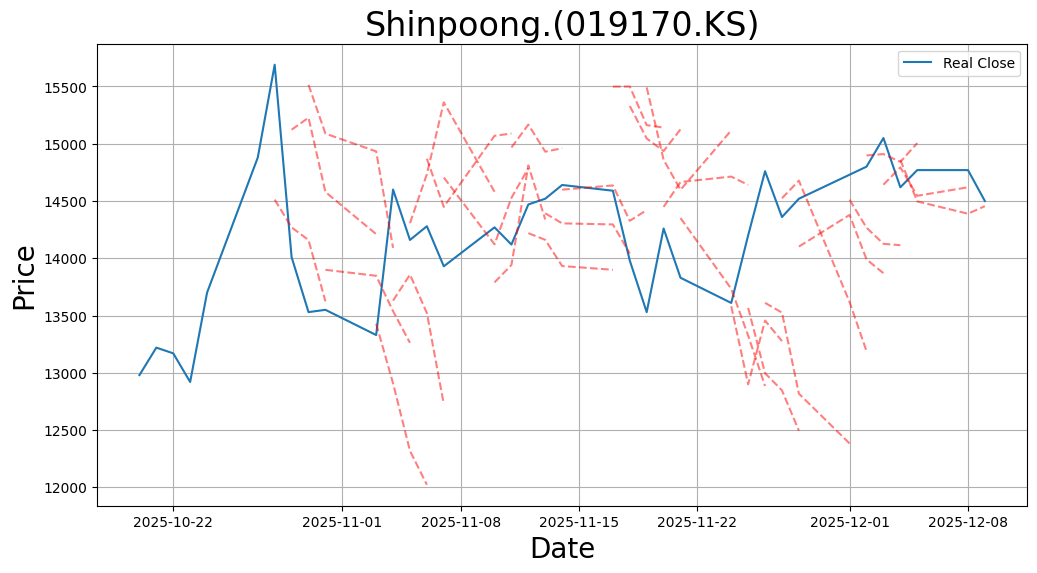

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


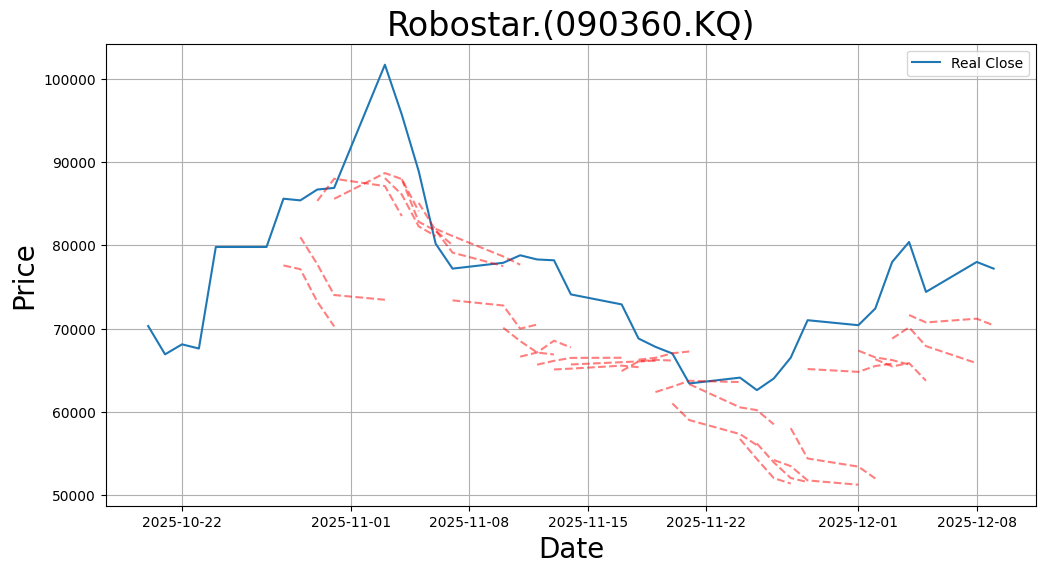

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


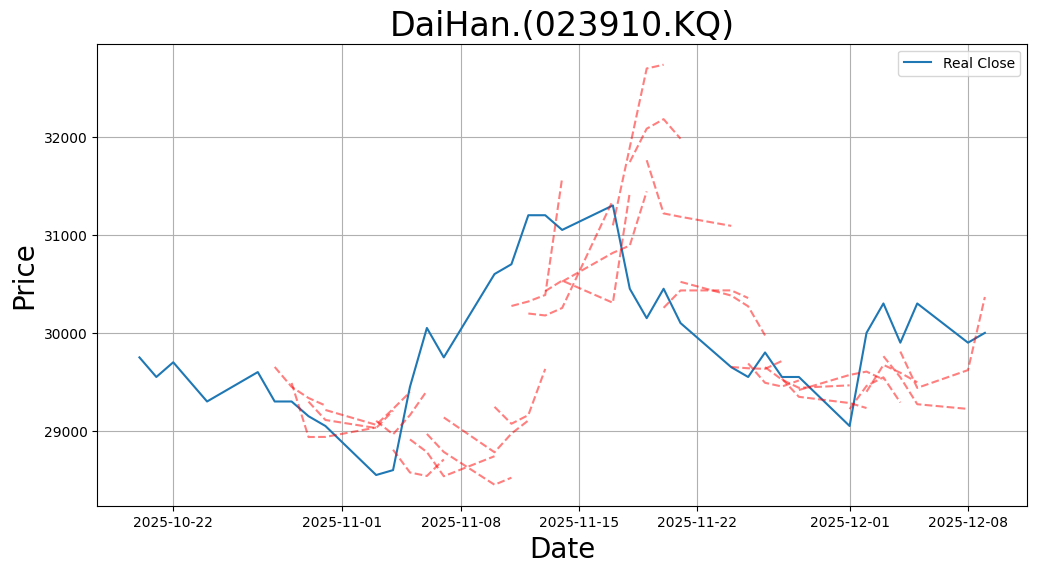

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


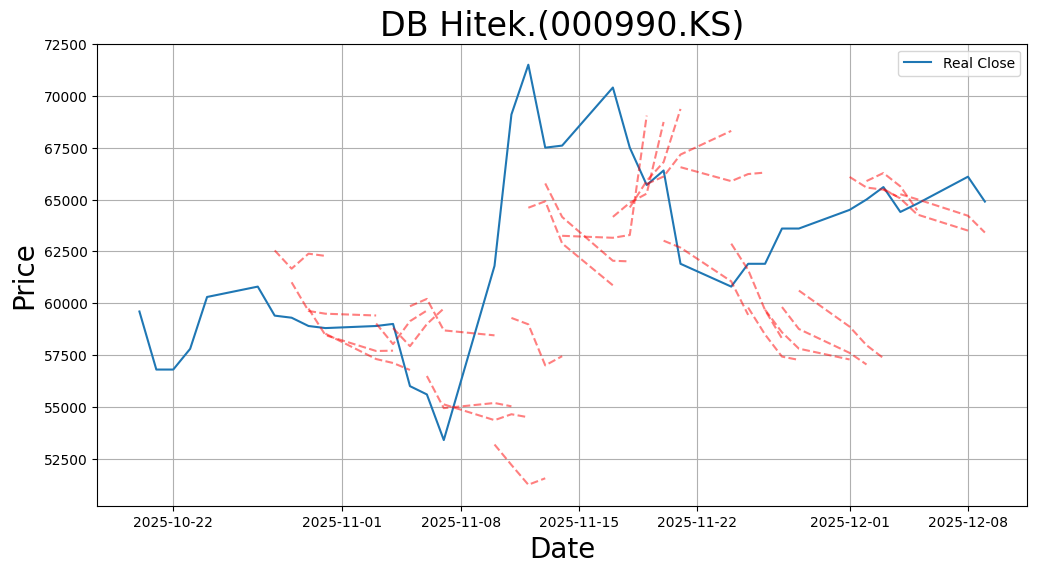

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


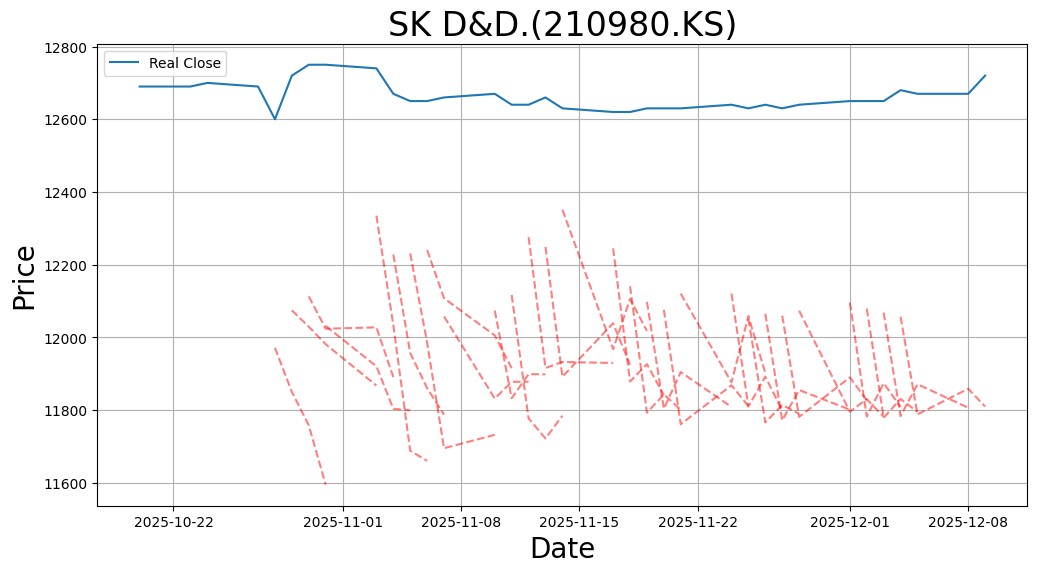

| 종목명                |   MSE (평균 제곱 오차) |   RMSE (제곱근 평균 제곱 오차) |    RMSE |              MSE |
|:----------------------|-----------------------:|-------------------------------:|--------:|-----------------:|
| Shinpoong.(019170.KS) |       921279           |                        959.833 |  959.83 | 921279           |
| Robostar.(090360.KQ)  |            8.90308e+07 |                       9435.61  | 9435.61 |      8.90308e+07 |
| DaiHan.(023910.KQ)    |       891220           |                        944.045 |  944.04 | 891220           |
| DB Hitek.(000990.KS)  |            3.36179e+07 |                       5798.09  | 5798.09 |      3.36179e+07 |
| SK D&D.(210980.KS)    |       557867           |                        746.905 |  746.91 | 557867           |


In [17]:
##4일 통으로 예측

import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
from sklearn.metrics import mean_squared_error

def denormalize(y_norm, min_vals, max_vals,feature_indices=[0,1,2,3]):
    y = y_norm.copy()
    for i, idx in enumerate(feature_indices):
        y[:, i] = y[:, i] * (max_vals[idx] - min_vals[idx]) + min_vals[idx]
    return y

def denormalize_std(y_norm, mean_vals, std_vals, feature_indices=[0,1,2,3]):
    y = y_norm.copy()
    for idx in feature_indices:
        y[..., idx] = y[..., idx] * std_vals[idx] + mean_vals[idx]
    return y


def recursive_predict(
    model,
    x_start_norm,
    future_days=4,
    price_feat_idx=[0,1,2,3]
):
    preds = []
    x_cur = x_start_norm.copy()   # (lookback, features)

    for _ in range(future_days):
        y_pred_norm = model.predict(
            x_cur[np.newaxis, ...],
            verbose=0
        )
        next_day = y_pred_norm[0, 0]   # (4,)
        preds.append(next_day)

        # 입력 갱신 (shift + 예측값 삽입)
        x_next = x_cur.copy()
        x_next[:-1] = x_cur[1:]
        x_next[-1, price_feat_idx] = next_day
        x_cur = x_next

    return np.array(preds)   # (4, 4)

# 모델 로드
best_model = load_model("best_model.h5")

# minmax_vals = [
#     [sp_min, sp_max],
#     [rbs_min, rbs_max],
#     [dh_min, dh_max],
#     [dbh_min, dbh_max],
#     [skd_min, skd_max]
# ]

std_vals = [
    (sp_mean, sp_std),
    (rbs_mean, rbs_std),
    (dh_mean, dh_std),
    (dbh_mean, dbh_std),
    (skd_mean, skd_std)
]


titles = [
    "Shinpoong.(019170.KS)",
    "Robostar.(090360.KQ)",
    "DaiHan.(023910.KQ)",
    "DB Hitek.(000990.KS)",
    "SK D&D.(210980.KS)"
]

future_days = 4
all_mse = []
all_rmse = []
# 테스트 루프 (4일 통 예측)
for i, data in enumerate(np_test_list_norm):
    test_data_norm = data.copy()
    x_test_norm, y_true_norm = [], []

    # future=4를 사용했으므로 range는 (data.shape[0] - lookback - future + 1) 로 변경
    for idx in range(data.shape[0] - lookback - future + 1):
        x_test_norm.append(data[idx:idx+lookback])
        y_true_norm.append(data[idx+lookback:idx+lookback+future,0:4])

    x_test_norm = np.array(x_test_norm)
    y_true_norm = np.array(y_true_norm)

    # 예측: 모델에 테스트 데이터를 한 번에 넣고 4일치 예측 결과를 얻음
    y_pred_norm = best_model.predict(x_test_norm)

    # ... (역정규화 코드 생략, 기존 코드의 mean/std 활용)
    mean_vals, std_vals_i = std_vals[i]

    test_data = test_data_norm.copy()
    test_data[:,0:4] = denormalize_std(
        test_data[:,0:4],
        mean_vals,
        std_vals_i
    )

    y_true = denormalize_std(y_true_norm, mean_vals, std_vals_i)
    y_pred = denormalize_std(y_pred_norm, mean_vals, std_vals_i)

    # Plot (4일 통 예측 결과 시각화)
    plt.figure(figsize=(12,6))
    dates_full = shinpoong_pharm_finance.index[shinpoong_test_idx]

    plt.plot(dates_full, test_data[:,0], label="Real Close")

    # 예측 결과를 실제 시점(dates_full)에 맞게 그리기
    for w in range(len(y_pred)):
        base_idx = w + lookback
        dates_w = dates_full[base_idx:base_idx+future]

        # y_pred[w, :, 0] 는 w 시점에서 예측한 미래 4일의 Close 가격
        plt.plot(
            dates_w,
            y_pred[w, :, 0],
            color='red',
            alpha=0.5,
            linestyle='--'
        )
    y_true_close = y_true[..., 0].flatten()
    y_pred_close = y_pred[..., 0].flatten()

    # MSE 및 RMSE 계산
    mse = mean_squared_error(y_true_close, y_pred_close)
    rmse = np.sqrt(mse)

    all_mse.append(mse)
    all_rmse.append(rmse)

    plt.title(titles[i], fontsize=24)
    plt.xlabel("Date", fontsize=20)
    plt.ylabel("Price", fontsize=20)
    plt.legend()
    plt.grid(True)
    plt.show()
results_df = pd.DataFrame({
    '종목명': titles,
    'MSE (평균 제곱 오차)': all_mse,
    'RMSE (제곱근 평균 제곱 오차)': all_rmse
})

results_df['RMSE'] = results_df['RMSE (제곱근 평균 제곱 오차)'].round(2)
results_df['MSE'] = results_df['MSE (평균 제곱 오차)'].round(2)

print(results_df.to_markdown(index=False))

In [9]:
# import matplotlib.pyplot as plt
# from keras.models import load_model

# def denormalize(y_norm, min_vals, max_vals,feature_indices=[0,1,2,3]):
#     y = y_norm.copy()
#     for i, idx in enumerate(feature_indices):
#         y[:, i] = y[:, i] * (max_vals[idx] - min_vals[idx]) + min_vals[idx]
#     return y

# def denormalize_std(y_norm, mean_vals, std_vals, feature_indices=[0,1,2,3]):
#     y = y_norm.copy()
#     for idx in feature_indices:
#         y[..., idx] = y[..., idx] * std_vals[idx] + mean_vals[idx]
#     return y


# def recursive_predict(
#     model,
#     x_start_norm,
#     future_days=4,
#     price_feat_idx=[0,1,2,3]
# ):
#     preds = []
#     x_cur = x_start_norm.copy()   # (lookback, features)

#     for _ in range(future_days):
#         y_pred_norm = model.predict(
#             x_cur[np.newaxis, ...],
#             verbose=0
#         )
#         next_day = y_pred_norm[0, 0]   # (4,)
#         preds.append(next_day)

#         # 입력 갱신 (shift + 예측값 삽입)
#         x_next = x_cur.copy()
#         x_next[:-1] = x_cur[1:]
#         x_next[-1, price_feat_idx] = next_day
#         x_cur = x_next

#     return np.array(preds)   # (4, 4)

# # =========================
# # 모델 로드
# # =========================
# best_model = load_model("best_model.h5")

# # minmax_vals = [
# #     [sp_min, sp_max],
# #     [rbs_min, rbs_max],
# #     [dh_min, dh_max],
# #     [dbh_min, dbh_max],
# #     [skd_min, skd_max]
# # ]

# std_vals = [
#     (sp_mean, sp_std),
#     (rbs_mean, rbs_std),
#     (dh_mean, dh_std),
#     (dbh_mean, dbh_std),
#     (skd_mean, skd_std)
# ]


# titles = [
#     "Shinpoong.(019170.KS)",
#     "Robostar.(090360.KQ)",
#     "DaiHan.(023910.KQ)",
#     "DB Hitek.(000990.KS)",
#     "SK D&D.(210980.KS)"
# ]

# future_days = 4

# # =========================
# # 테스트 루프
# # =========================
# for i, data in enumerate(np_test_list_norm):

#     # -------- 데이터 구성 --------
#     x_test_norm = []
#     for idx in range(data.shape[0] - lookback - 1):
#         x_test_norm.append(data[idx:idx+lookback])

#     x_test_norm = np.array(x_test_norm)
#     dates = shinpoong_pharm_finance.index[shinpoong_test_idx]
#     test_data = data.copy()

#     # -------- Recursive 예측 --------
#     all_preds_norm = []
#     for w in range(len(x_test_norm)):
#         preds_4 = recursive_predict(
#             best_model,
#             x_test_norm[w],
#             future_days=future_days
#         )
#         all_preds_norm.append(preds_4)

#     all_preds_norm = np.array(all_preds_norm)
#     # shape: (N, 4, 4)

#     # -------- 역정규화 --------
#     # test_data[:,0:4] = denormalize(
#     #     test_data[:,0:4],
#     #     minmax_vals[i][0],
#     #     minmax_vals[i][1]
#     # )

#     # all_preds = denormalize(
#     #     all_preds_norm.reshape(-1,4),
#     #     minmax_vals[i][0],
#     #     minmax_vals[i][1]
#     # ).reshape(all_preds_norm.shape)
#     mean_vals, std_vals_i = std_vals[i]

#     test_data = test_data.copy()
#     test_data[:,0:4] = denormalize_std(
#         test_data[:,0:4],
#         mean_vals,
#         std_vals_i
#     )

#     all_preds = denormalize_std(
#         all_preds_norm,
#         mean_vals,
#         std_vals_i
#     )

#     # =========================
#     # Plot
#     # =========================
#     plt.figure(figsize=(12,6))
#     plt.plot(dates, test_data[:,0], label="Real Close")

#     for w in range(len(all_preds)):
#         base = w + lookback
#         dates_w = dates[base:base+future_days]
#         if len(dates_w) < future_days:
#             break

#         plt.plot(
#             dates_w,
#             all_preds[w, :, 0],   # Close
#             color="red",
#             linestyle="--",
#             alpha=0.3
#         )

#     plt.title(titles[i])
#     plt.xlabel("Date")
#     plt.ylabel("Price")
#     plt.legend()
#     plt.grid(True)
#     plt.show()


##실제 예측

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


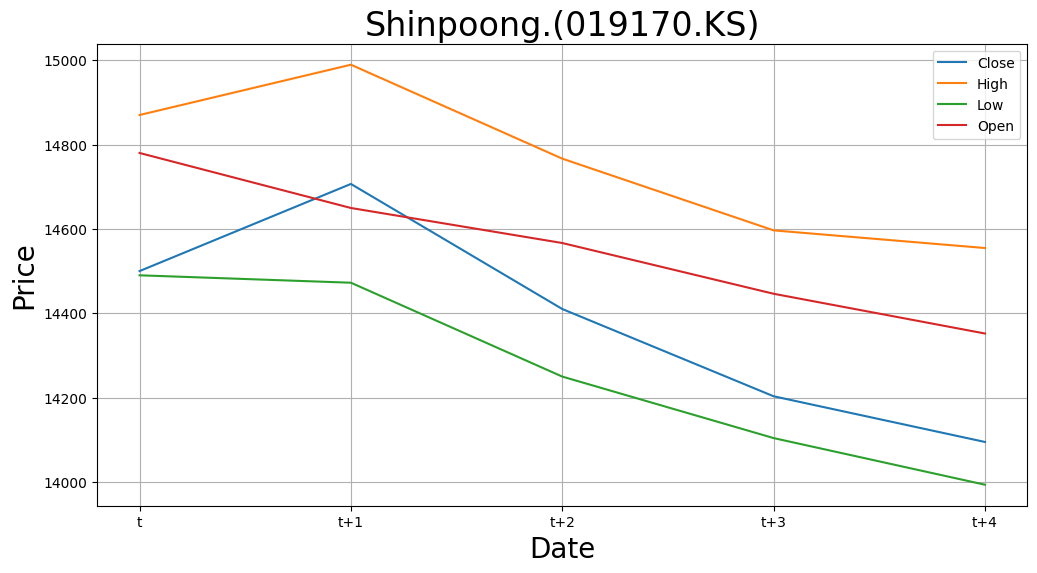

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


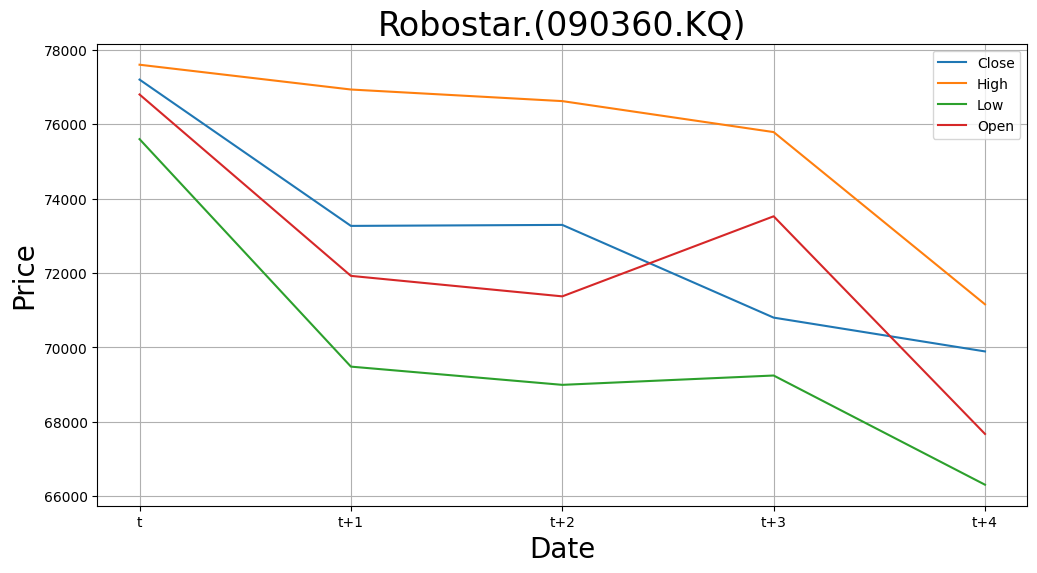

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


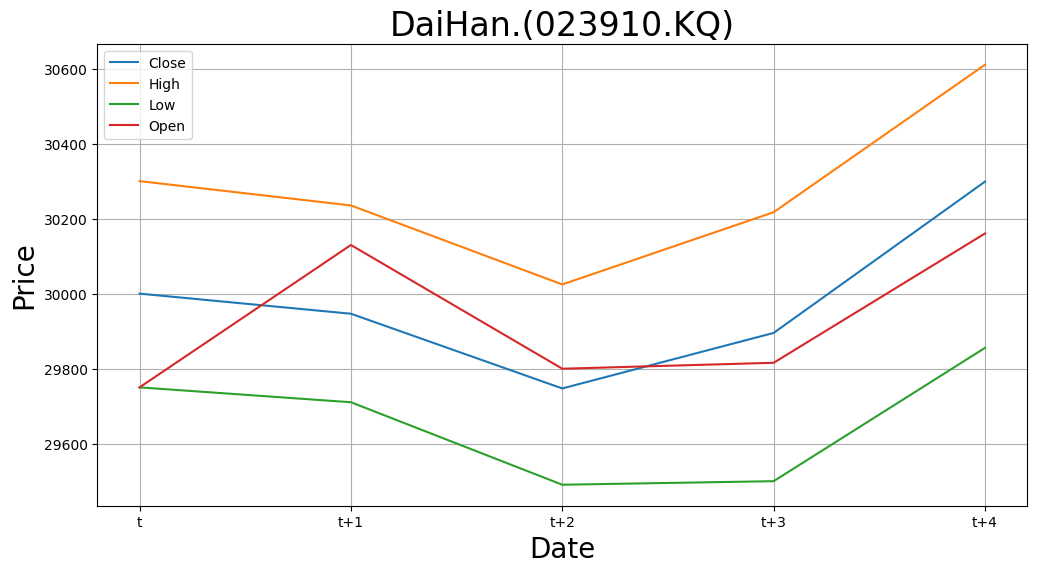

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


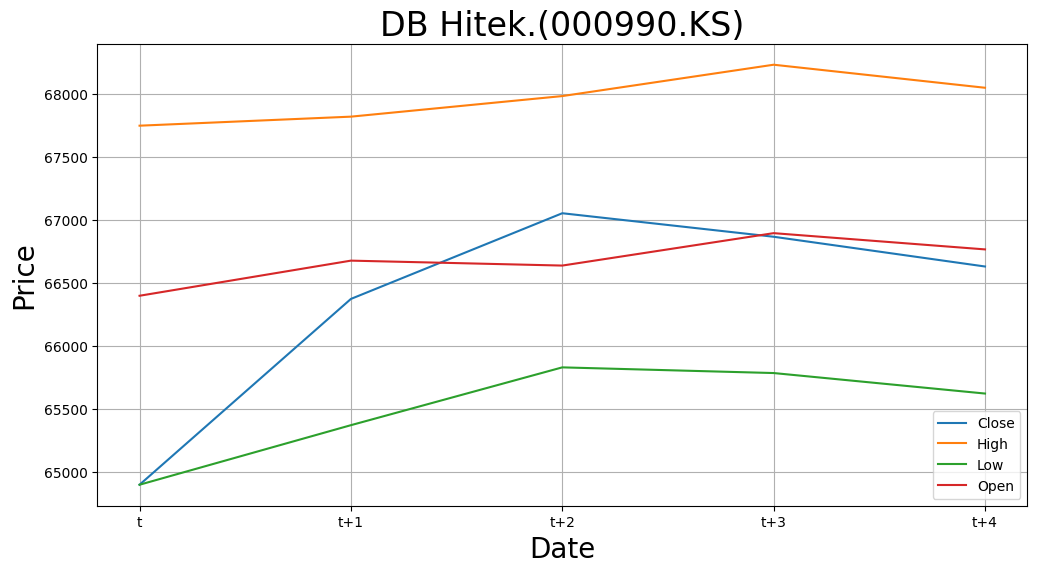

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


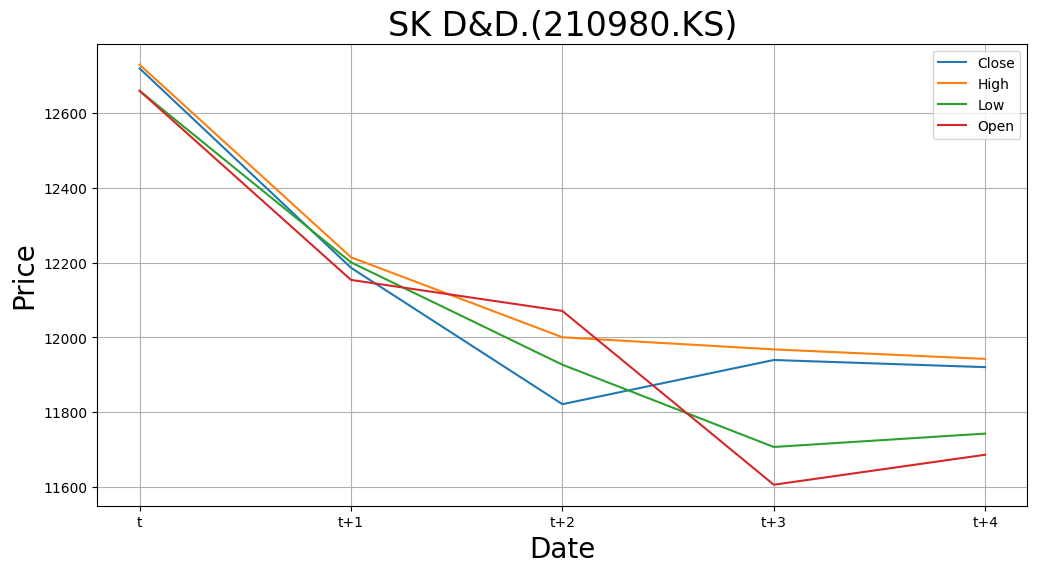

In [78]:
## 실제 예측

import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
from sklearn.metrics import mean_squared_error

titles = [
    "Shinpoong.(019170.KS)",
    "Robostar.(090360.KQ)",
    "DaiHan.(023910.KQ)",
    "DB Hitek.(000990.KS)",
    "SK D&D.(210980.KS)"
]

future_days = 4
feature_names = ["Close","High","Low", "Open"]
time_steps = ["t","t+1","t+2","t+3","t+4"]
all_csv_results = []
np_finance_list= [np_sp[-1,0:4], np_rbs[-1,0:4], np_dh[-1,0:4],np_dbh[-1,0:4],np_skd[-1,0:4]]


# 테스트 루프 (4일 통 예측)
for i, data in enumerate(np_test_list_norm):
    X_norm = data[-lookback:]

    X_norm = X_norm[np.newaxis, ...]
    Y_pred_norm = best_model.predict(X_norm)
    mean_vals, std_vals_i = std_vals[i]
    Y_pred = denormalize_std(Y_pred_norm[:,0:4],mean_vals,std_vals_i)
    Y_pred=Y_pred.reshape(-1,4)
    np_finance_list[i] = np_finance_list[i][np.newaxis,:]
    t_data_real = np_finance_list[i]
    combined_pred = np.vstack([t_data_real[:,0:4], Y_pred])

    df_pred = pd.DataFrame(
        combined_pred,
        index=time_steps, # Time Step을 Index로 사용
        columns=[f"{name}_Price" for name in feature_names]
    )

    stock_title_simple = titles[i].split('.')[0]
    filename = f"future_5day_{stock_title_simple}.csv" # 파일명 변경

    #df_pred.to_csv(filename, float_format='%.2f')

    df_pred_reset = df_pred.reset_index().rename(columns={'index': 'Time_Step'})
    df_pred_reset.insert(0, 'Stock', stock_title_simple)
    all_csv_results.append(df_pred_reset)

    plt.figure(figsize=(12,6))
    for j in range(4):
        plt.plot(date_x, combined_pred[:, j], label=feature_names[j])


    plt.title(titles[i], fontsize=24)
    plt.xlabel("Date", fontsize=20)
    plt.ylabel("Price", fontsize=20)
    plt.legend()
    plt.grid(True)
    plt.show()

final_combined_df = pd.concat(all_csv_results, ignore_index=True)
final_csv_name = "future_5day.csv"
final_combined_df.to_csv(final_csv_name, index=False, float_format='%.2f')


In [77]:

np_finance_list= [np_sp[-1,0:4], np_rbs[-1,0:4], np_dh[-1,0:4],np_dbh[-1,0:4],np_skd[-1,0:4]]
np_finance_list[0] = np_finance_list[0][np.newaxis,:]
print(np_finance_list[0].shape)

(1, 4)
